# Tuning models for classification of Ar41
From previous notebook, several models deserve a better investigation:
- Linear SVM, **DTree**, Logistic Regression: easy rule extraction
- **Random Forest, AdaBoost**: ensemble
- MLP: deep learning

In [12]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 45})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
# Load Ar39
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Ar39_08_18_2020", "Ar39_Snapshots")

fileprefix = "Snapshot1Ar39*"
dfall1ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot2Ar39*"
dfall2ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot3Ar39*"
dfall3ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot4Ar39*"
dfall4ar39 = load_dataframe_from_files(dirin, fileprefix)

print("[Info] Loaded all 1, 2, 3, 4 Ar39 Pileups in {:.2f} seconds".format(time.time() - init))

# Load Ar41
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Neutrons_Cut1000mm_09_04_2020", "Neutrons_Snapshots")

fileprefix = "SnapshotAr41*"
dfallar41 = load_dataframe_from_files(dirin, fileprefix)
print("[Info] Loaded all Ar41 in {:.2f} seconds".format(time.time() - init))

[Info] Loading 100 files wt prefix:
Snapshot1Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot2Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot3Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot4Ar39*
...................................................................................................
[Info] Loaded all 1, 2, 3, 4 Ar39 Pileups in 131.66 seconds
[Info] Loading 1 files wt prefix:
SnapshotAr41*

[Info] Loaded all Ar41 in 0.02 seconds


# data selection: consider only instances wt 5<=NPE<=50

In [4]:
dfcut1ar39 = dfall1ar39[(dfall1ar39.pedetected>=5) & (dfall1ar39.pedetected<=50)]
dfcut2ar39 = dfall2ar39[(dfall2ar39.pedetected>=5) & (dfall2ar39.pedetected<=50)]
dfcut3ar39 = dfall3ar39[(dfall3ar39.pedetected>=5) & (dfall3ar39.pedetected<=50)]
dfcut4ar39 = dfall4ar39[(dfall4ar39.pedetected>=5) & (dfall4ar39.pedetected<=50)]
dfcutar41 = dfallar41[(dfallar41.pedetected>=5) & (dfallar41.pedetected<=50)]

# remove test data for ar41

In [5]:
n_test_ar41 = round(.10 * len(dfcutar41))
id_ar41 = np.arange(len(dfcutar41))
np.random.shuffle(id_ar41)
test_ar41, train_ar41 = dfcutar41.iloc[id_ar41[:n_test_ar41], :], dfcutar41.iloc[id_ar41[n_test_ar41:], :]

print("[Info] We keep {} instances for testing, the remaining {} instances from train/validation".format(len(test_ar41), len(train_ar41)))

[Info] We keep 720 instances for testing, the remaining 6483 instances from train/validation


# undersample ar39

In [6]:
def undersample_argon(ar39_df, number_of_instances=1000, augment_from_pe=35, augmentation_nr=5,
                      skip_first_cols=2, nslices=72):
    bins = np.linspace(0, ar39_df.pedetected.max()+1, ar39_df.pedetected.max()+2)
    bin_cont, bin_edges, _ = plt.hist(ar39_df.pedetected, bins=bins, density=True, label="Ar39", edgecolor='w')
    # compute the nr of samples for each PE value,
    # to undersample ar39 keeping the same distribution
    avail_instances_per_pe = np.array([len(ar39_df[ar39_df.pedetected==pe]) for pe in range(0, ar39_df.pedetected.max()+1)])
    nr_ar_samples_per_pe = np.array(np.where(np.ceil(bin_cont*number_of_instances)<=avail_instances_per_pe, np.ceil(bin_cont*number_of_instances), number_of_instances), dtype=int)
    # Introduce a small bias on instances with "high" PE value
    # to avoid to have just a few samples (e.g. 30,40,50,60 PE)
    scaled_ar39 = pd.DataFrame()
    for pe in range(1, ar39_df.pedetected.max()+1):
        if pe > augment_from_pe:
            nr_instances = augmentation_nr
        else:
            nr_instances = nr_ar_samples_per_pe[pe]
        scaled_ar39 = pd.concat([scaled_ar39, ar39_df[ar39_df.pedetected==pe].iloc[:nr_instances]])
    AA = scaled_ar39.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy()
    np.random.shuffle(AA)    # to avoid order by PE
    return pd.DataFrame(AA)

[Info] Undersampling in 17.401 seconds.
[Info] Selected 6697 instances


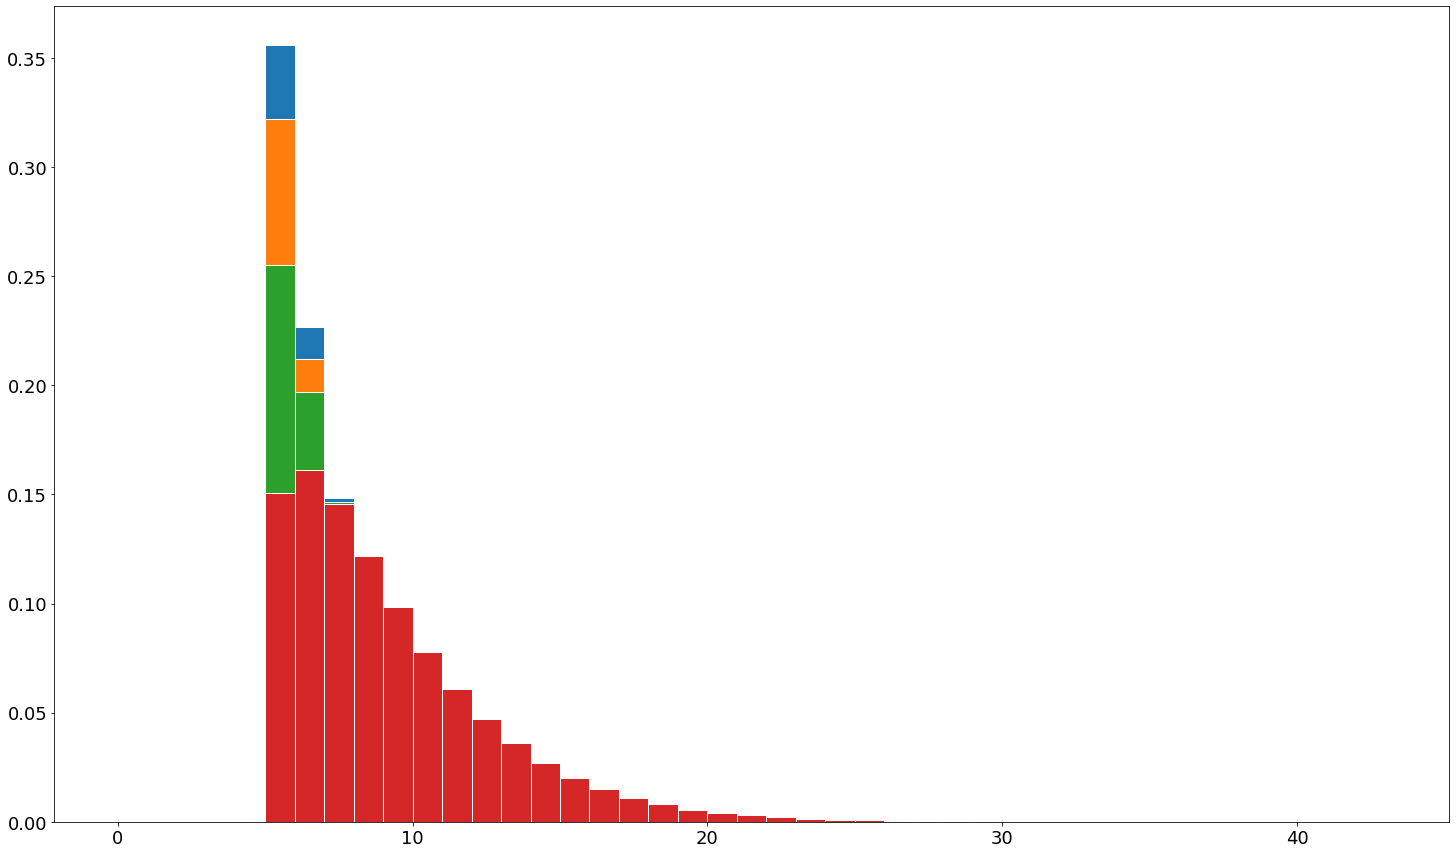

In [7]:
init = time.time()
skip_first_cols, n_inner_slices, n_outer_slices = 3, 12, 20

train_1ar39 = undersample_argon(dfcut1ar39, round(len(train_ar41)*.30), augment_from_pe=20, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
train_2ar39 = undersample_argon(dfcut2ar39, round(len(train_ar41)*.30), augment_from_pe=25, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
train_3ar39 = undersample_argon(dfcut3ar39, round(len(train_ar41)*.20), augment_from_pe=30, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
train_4ar39 = undersample_argon(dfcut4ar39, round(len(train_ar41)*.20), augment_from_pe=35, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
print("[Info] Undersampling in {:.3f} seconds.".format(time.time() - init))

# compact ar39 training data
train_ar39 = pd.concat([train_1ar39, train_2ar39, train_3ar39, train_4ar39], axis=0)
print("[Info] Selected {} instances".format(len(train_ar39)))

# features selection

In [8]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def mean_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.mean(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def std_npe(row):
    return np.std(row.to_numpy())

def std_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.std(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

In [9]:
# Compute features muon
import time

init = time.time()
df_ar41_feat = pd.DataFrame()
df_ar41_feat["PEDetected_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar41_feat["NActiveSlices_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar41_feat["MeanNPEActive_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar41_feat["StdNPEActive_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
df_ar41_feat["SpatialRange_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_ar41_feat["SpatialVar_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
df_ar41_feat["SpatialStd_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar41_feat["PEDetected_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar41_feat["NActiveSlices_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar41_feat["MeanNPEActive_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar41_feat["StdNPEActive_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
df_ar41_feat["SpatialRange_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_ar41_feat["SpatialVar_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
df_ar41_feat["SpatialStd_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar41_feat["PEDetected_tot"] = df_ar41_feat["PEDetected_inner"] + df_ar41_feat["PEDetected_outer"]
df_ar41_feat["NActiveSlices_tot"] = df_ar41_feat["NActiveSlices_inner"] + df_ar41_feat["NActiveSlices_outer"]
df_ar41_feat["MeanNPEActive_tot"] = df_ar41_feat["PEDetected_tot"] / df_ar41_feat["NActiveSlices_tot"]
df_ar41_feat = df_ar41_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

init = time.time()
df_ar39_feat = pd.DataFrame()
df_ar39_feat["PEDetected_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar39_feat["NActiveSlices_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar39_feat["MeanNPEActive_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar39_feat["StdNPEActive_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
df_ar39_feat["SpatialRange_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_ar39_feat["SpatialVar_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
df_ar39_feat["SpatialStd_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar39_feat["PEDetected_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar39_feat["NActiveSlices_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar39_feat["MeanNPEActive_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar39_feat["StdNPEActive_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
df_ar39_feat["SpatialRange_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_ar39_feat["SpatialVar_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
df_ar39_feat["SpatialStd_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar39_feat["PEDetected_tot"] = df_ar39_feat["PEDetected_inner"] + df_ar39_feat["PEDetected_outer"]
df_ar39_feat["NActiveSlices_tot"] = df_ar39_feat["NActiveSlices_inner"] + df_ar39_feat["NActiveSlices_outer"]
df_ar39_feat["MeanNPEActive_tot"] = df_ar39_feat["PEDetected_tot"] / df_ar39_feat["NActiveSlices_tot"]
df_ar39_feat = df_ar39_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 1.016 sec
Compute Mu Outer features: 1.333 sec
Compute combined features: 0.006 sec
Compute Ar39 Inner features: 1.280 sec
Compute Ar39 Outer features: 1.373 sec
Compute combined features: 0.003 sec


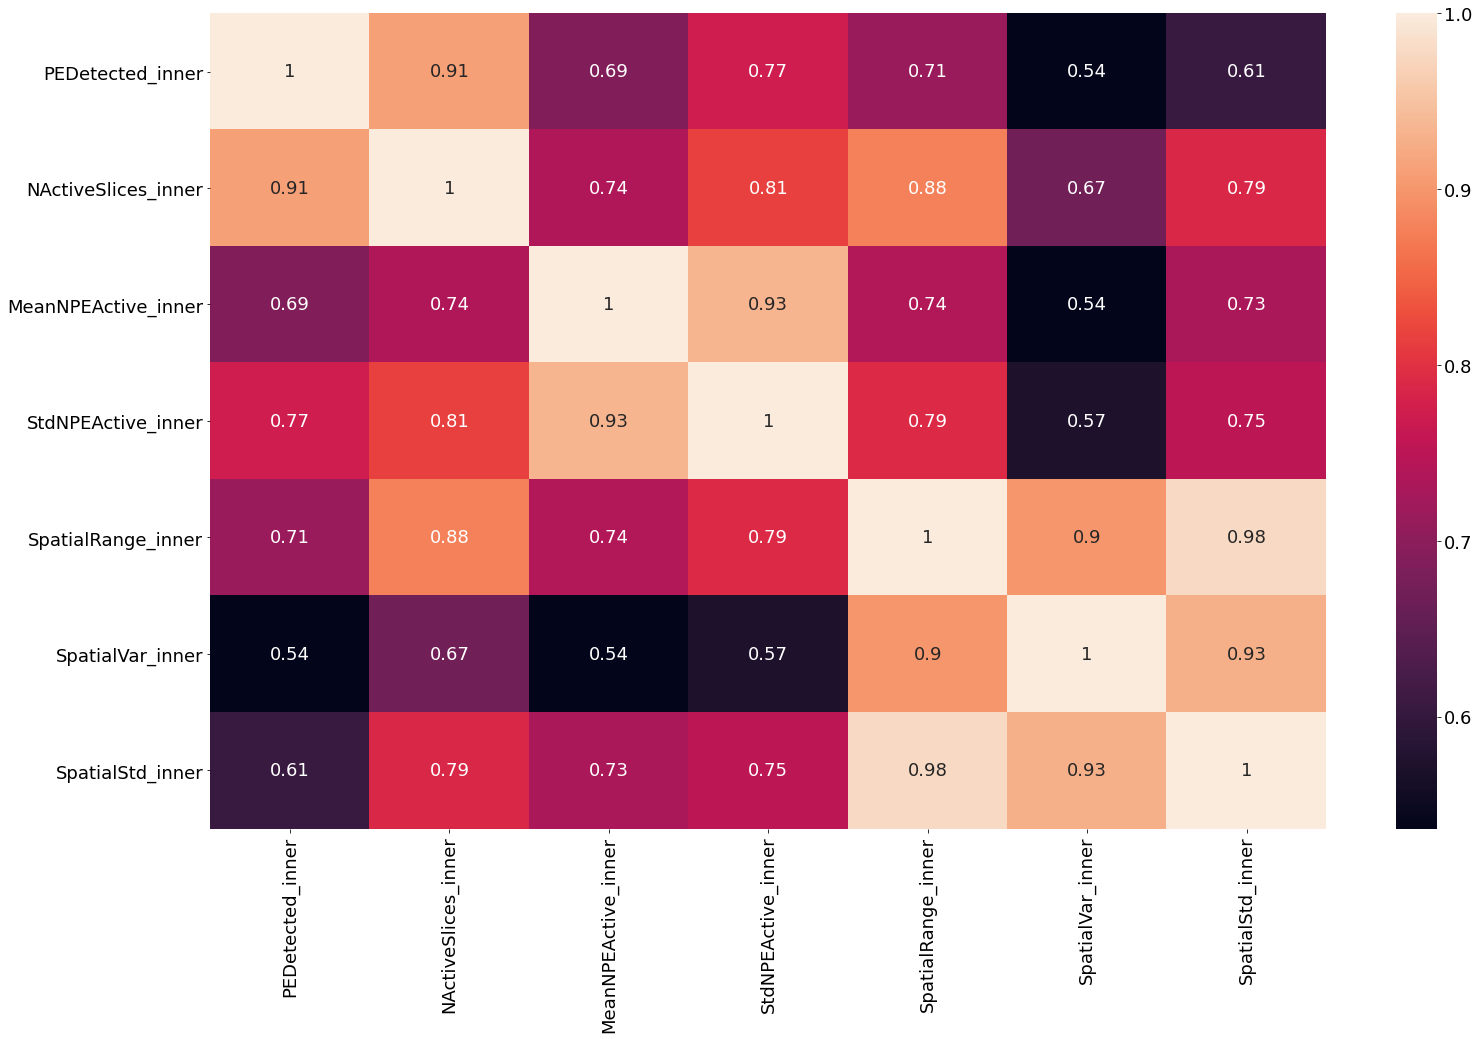

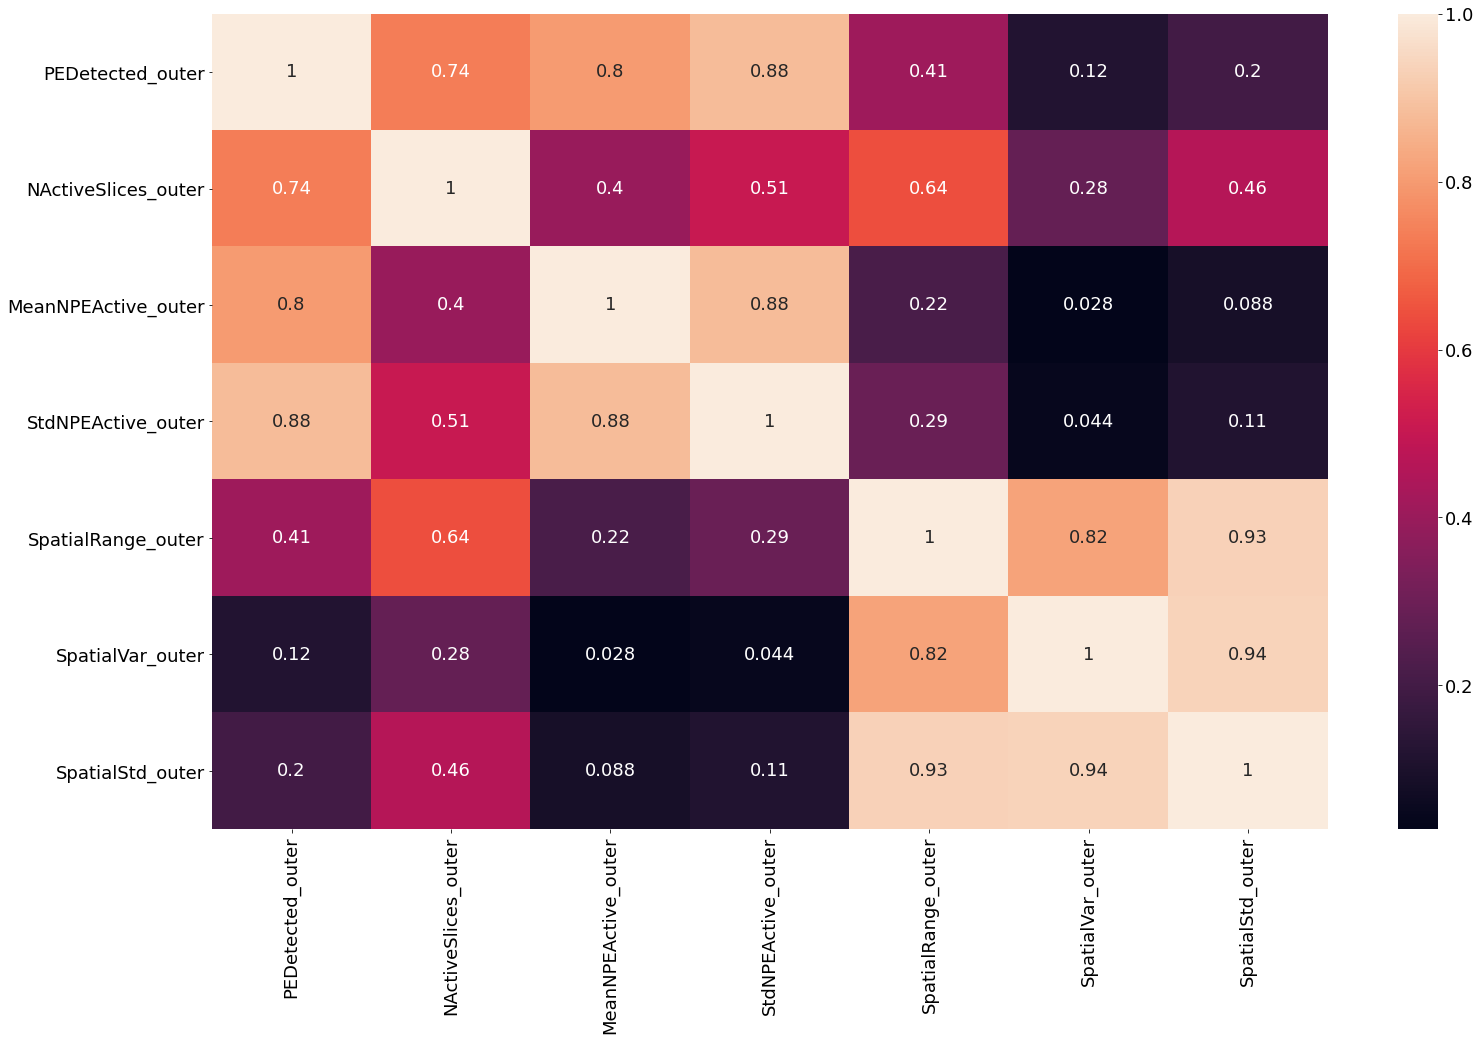

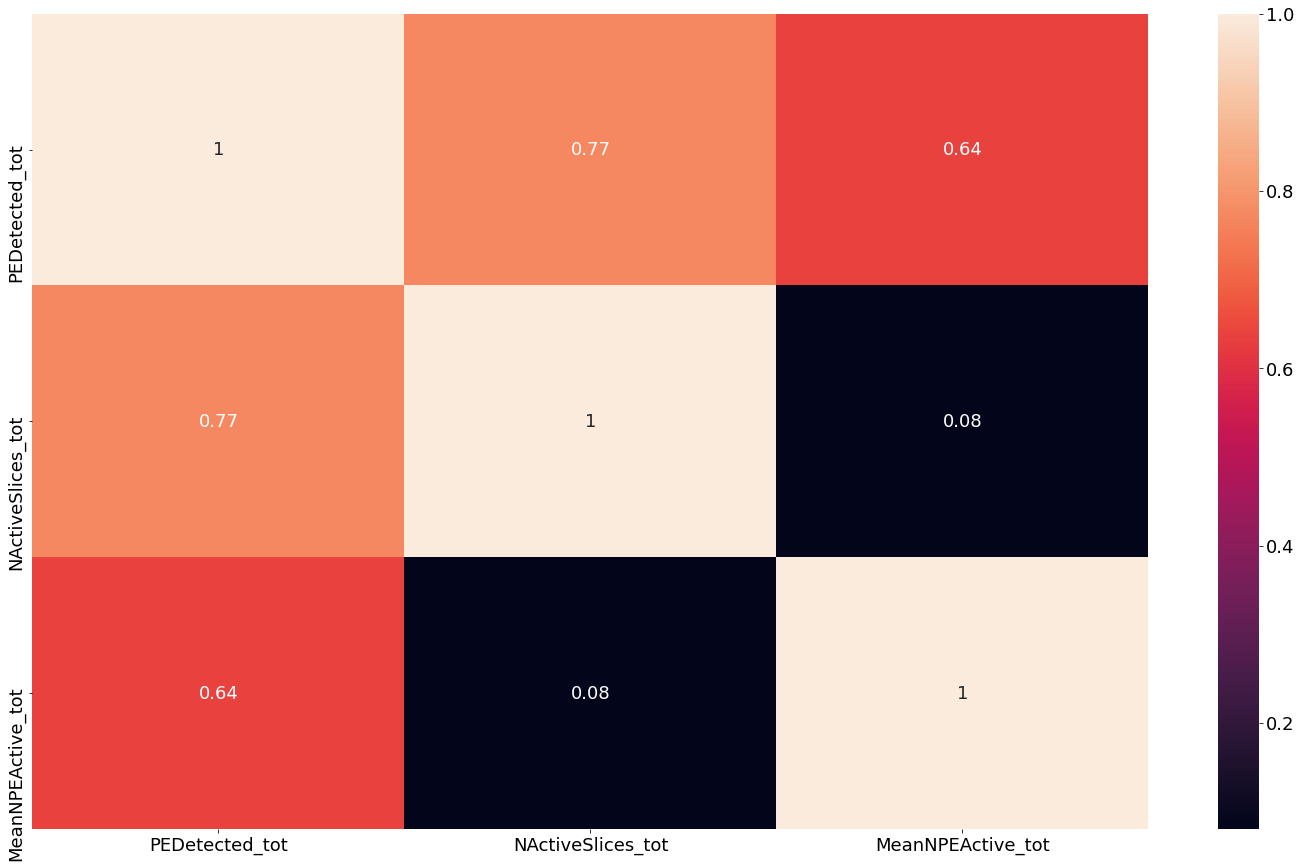

In [10]:
import seaborn as sn

corr_matrix = pd.concat([df_ar41_feat.iloc[:, :7], df_ar39_feat.iloc[:, :7]]).corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

corr_matrix = pd.concat([df_ar41_feat.iloc[:, 7:14], df_ar39_feat.iloc[:, 7:14]]).corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

corr_matrix = pd.concat([df_ar41_feat.iloc[:, 14:], df_ar39_feat.iloc[:, 14:]]).corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

looking at the corr matrix, we select the following features (*less than 95% corr*):
- Inner/Outer features: PE Detected, Active Slices Mean NPE/Active, Spatial Range, Spatial Variance
- Tot features: PE Detected, Active Slices, Mean NPE/Active

In [11]:
selected_features = ["PEDetected_inner", "NActiveSlices_inner", "MeanNPEActive_inner", "SpatialVar_inner", "SpatialRange_inner",
                     "PEDetected_outer", "NActiveSlices_outer", "MeanNPEActive_outer", "SpatialVar_outer", "SpatialRange_outer",
                     "PEDetected_tot", "NActiveSlices_tot", "MeanNPEActive_tot"]

# train/val models

In [12]:
# ml imports
import sklearn.model_selection as model_selection
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.preprocessing import StandardScaler
# models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier, Lasso, PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix as cv
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier

In [13]:
names = ["Linear SVM",
         "Decision Tree", "Random Forest", "AdaBoost",
         "Naive Bayes",
         "Logistic Regression",
         "Ridge",
         "ElasticNet"]
classifiers = [
    SVC(kernel="linear", C=0.05),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=2, n_estimators=15, max_features='auto'),
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression(max_iter=500, C=.05),
    RidgeClassifier(), 
    SGDClassifier(penalty="elasticnet")
]

In [14]:
# data preparation
df_ar39_feat["y"] = 0
df_ar41_feat["y"] = 1
# data preparation
data = pd.concat([df_ar39_feat, df_ar41_feat], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = X.loc[:, selected_features]
X = np.array(X)
y = np.array(y)

[Info] KFold - Iteration 0 ........
[Info] KFold - Iteration 1 ........
[Info] KFold - Iteration 2 ........
[Info] KFold - Iteration 3 ........
[Info] KFold - Iteration 4 ........

Linear SVM: 0.86464
Decision Tree: 0.88520
Random Forest: 0.84590
AdaBoost: 0.89947
Naive Bayes: 0.80986
Logistic Regression: 0.86806
Ridge: 0.84340
ElasticNet: 0.85167


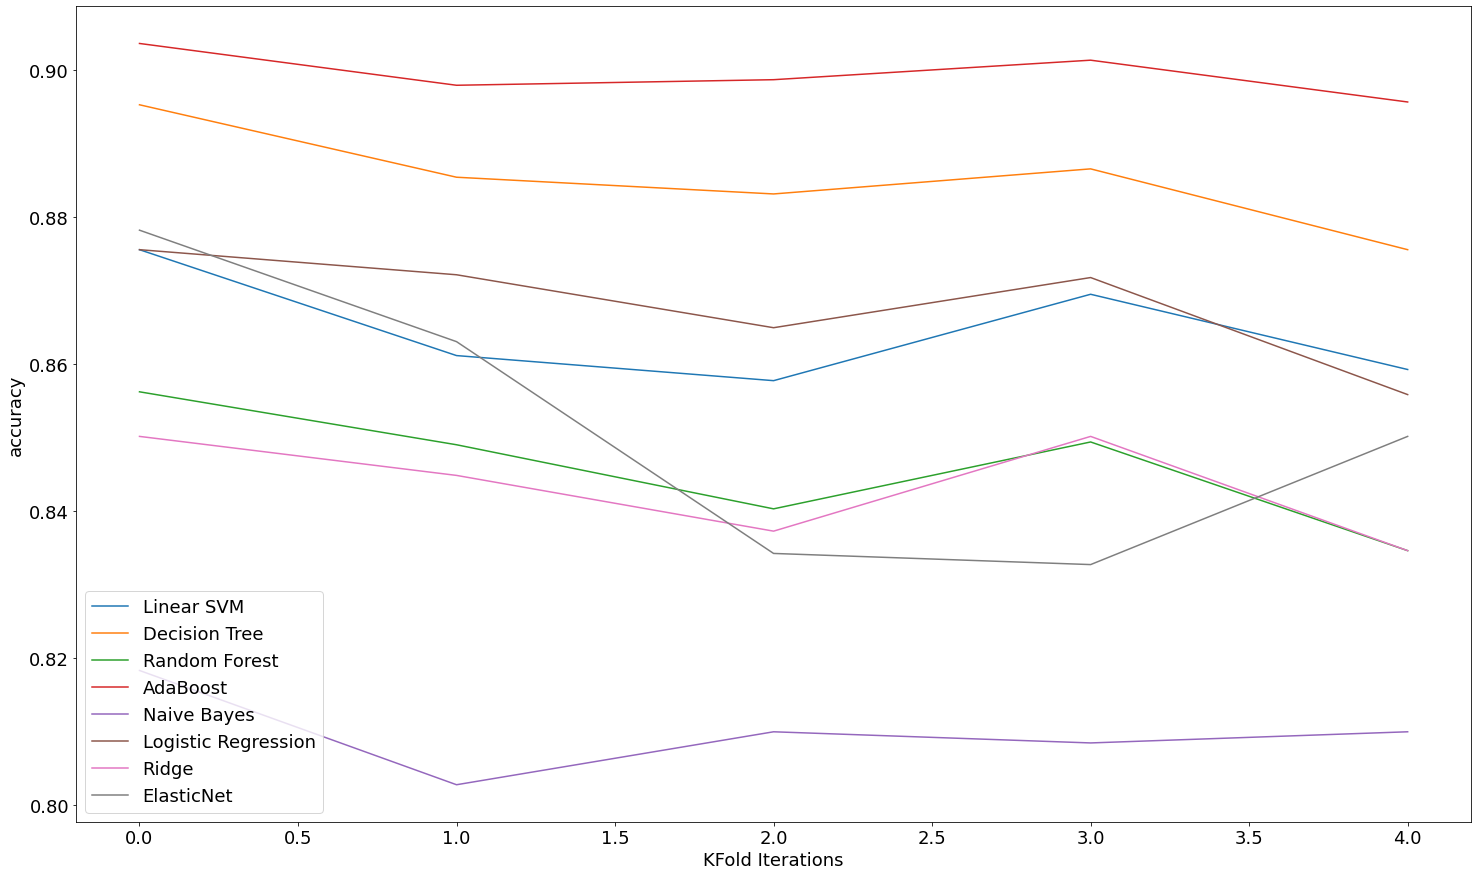

In [14]:
import time
from sklearn.model_selection import KFold

model_template   = "[Info] Model: {}"
result_template  = "[Info] Complete training in {:.3f} seconds.\n"
result_template += "[Result] Score: {:.3f}, Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}"
confusion_matrix = "[Info] TN: {}, FP: {}, FN: {}, TP: {}"

# Start kfold cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
evaluations = [[] for name in names]
for iteration, (train_ids, test_ids) in enumerate(kf.split(X)):
    print("[Info] KFold - Iteration {} ".format(iteration), end='')
    X_train, X_test = X[train_ids], X[test_ids]
    y_train, y_test = y[train_ids], y[test_ids]
    # iterate over classifiers
    for i, (name, clf) in enumerate(zip(names, classifiers)):
        print(".", end="")
        start = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - start
        score = clf.score(X_test, y_test)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred.round())
        precision = precision_score(y_test, y_pred.round())
        recall = recall_score(y_test, y_pred.round())
        tn, fp, fn, tp = cv(y_test, y_pred.round()).ravel()
        evaluations[i].append({'accuracy': accuracy, 'precision': precision, 'recall': recall})
    print()
print()
metric = "accuracy"
for i, name in enumerate(names):
    line = [eva[metric] for eva in evaluations[i]]
    plt.plot(range(len(line)), line, label=name)
    print("{}: {:.5f}".format(name, sum(line)/len(line)))
plt.xlabel("KFold Iterations")
plt.ylabel(metric)
plt.legend()
plt.show()

# tune adaboost

In [18]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [61]:
# first: tune base estimator
ada_param_grid = {"base_estimator__min_samples_split" : range(50, 500),
                 "base_estimator__max_features": ["auto", "log2", "sqrt"],
                 "n_estimators": range(10, 501)                 
                }

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=1))

# run grid search
random_grid_ada = RandomizedSearchCV(ada, param_distributions=ada_param_grid, n_iter=100, cv=5, verbose=2, n_jobs=-1)
random_grid_ada.fit(X, y)

print("[Info] Randomized Search + Cross-Validation")
print(random_grid_ada.best_params_)
print(random_grid_ada.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.0min finished


[Info] Randomized Search + Cross-Validation
{'n_estimators': 168, 'base_estimator__min_samples_split': 305, 'base_estimator__max_features': 'sqrt'}
0.8986342943854325


In [63]:
# first: tune base estimator
ada_param_grid = {"base_estimator__min_samples_split": range(280, 326, 10),
                  "n_estimators": range(50, 201, 25),
                  "learning_rate": np.linspace(.0, .5, 10)
             }

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, criterion="entropy", splitter="best", max_features="sqrt"))

# run grid search
grid_search_ada = GridSearchCV(ada, param_grid=ada_param_grid, scoring = 'accuracy', verbose=2, n_jobs=-1)
grid_search_ada.fit(X, y)

print("[Info] Grid Search + Cross-Validation")
print("[Info] Best params:")
print(grid_search_ada.best_params_)
print(grid_search_ada.best_score_)

Fitting 5 folds for each of 350 candidates, totalling 1750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 778 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1181 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1670 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:  5.2min finished


[Info] Grid Search + Cross-Validation
[Info] Best params:
{'base_estimator__min_samples_split': 280, 'learning_rate': 0.4444444444444444, 'n_estimators': 150}
0.8986342943854325


In [65]:
# first ada: n estimators, learning rate
ada_param_grid = {"n_estimators": range(120, 181, 5),
                  "learning_rate": np.linspace(.1, .4, 10)}

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(splitter='best', criterion='entropy', max_features='log2', min_samples_split=280, max_depth=1))

# run grid search
grid_search_ada = GridSearchCV(ada, param_grid=ada_param_grid, scoring = 'accuracy', n_jobs=-1, verbose=2)
grid_search_ada.fit(X, y)

print("[Info] Grid Search + Cross-Validation")
print(grid_search_ada.best_params_)
print(grid_search_ada.best_score_)

Fitting 5 folds for each of 130 candidates, totalling 650 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 650 out of 650 | elapsed:  2.7min finished


[Info] Grid Search + Cross-Validation
{'learning_rate': 0.4, 'n_estimators': 150}
0.8954476479514415


In [19]:
# first ada: n estimators, learning rate
ada_param_grid = {"n_estimators": range(150, 301, 5),
                  "learning_rate": np.linspace(.05, .4, 15)}

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(splitter='best', criterion='entropy', max_features='log2', min_samples_split=280, max_depth=1))

# run grid search
grid_search_ada = GridSearchCV(ada, param_grid=ada_param_grid, scoring=['accuracy', 'precision'], refit='accuracy', n_jobs=-1, verbose=2)
grid_search_ada.fit(X, y)

print("[Info] Grid Search + Cross-Validation")
print(grid_search_ada.best_params_)
print(grid_search_ada.best_score_)

Fitting 5 folds for each of 465 candidates, totalling 2325 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 2325 out of 2325 | elapsed: 14.3min finished


[Info] Grid Search + Cross-Validation
{'learning_rate': 0.325, 'n_estimators': 275}
0.895371775417299


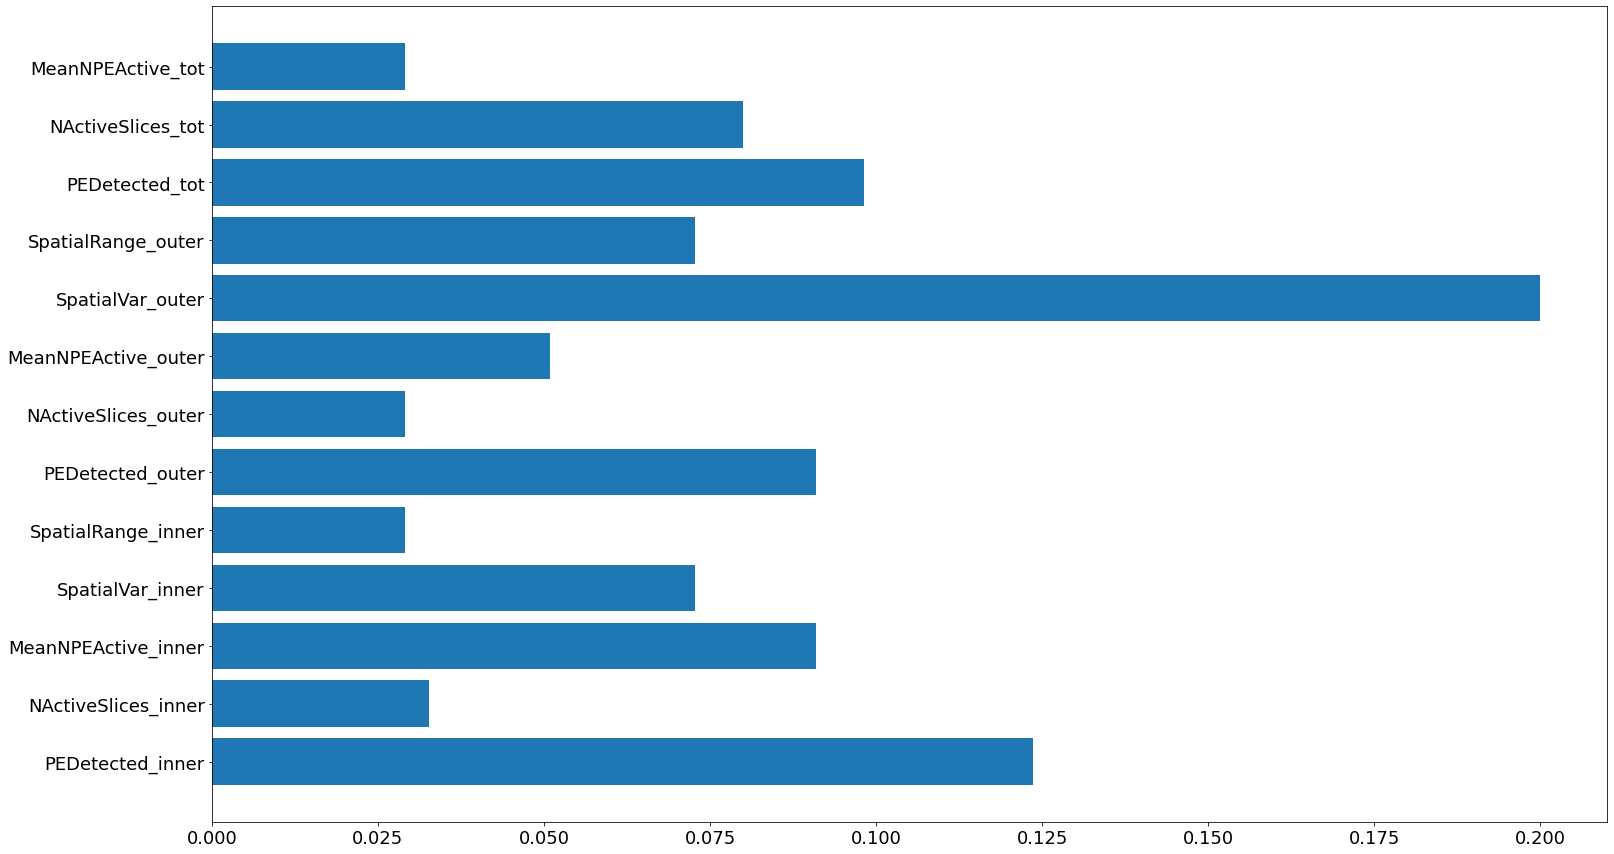

In [20]:
plt.barh(range(len(selected_features)), grid_search_ada.best_estimator_.feature_importances_)
plt.yticks(range(len(selected_features)), selected_features)
plt.show()

In [21]:
# train tuned model
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(splitter='best', criterion='entropy', max_features='log2', min_samples_split=280, max_depth=1),
                         n_estimators=275, learning_rate=.325)
ada.fit(X, y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=1,
                                                         max_features='log2',
                                                         min_samples_split=280),
                   learning_rate=0.325, n_estimators=275)

In [22]:
# note: adaboost compute probability based on the weight of each classifier
for i, dt in enumerate(ada.estimators_):
    print("Estimator {}:".format(i))
    classes = ["Ar39", "Ar41"]
    print("\t{} <= {:.3f}: {}".format(selected_features[dt.tree_.feature[0]], 
                                      dt.tree_.threshold[0],
                                      classes[np.argmax(dt.tree_.value[1][0])]))
    print("\t{} >  {:.3f}: {}".format(selected_features[dt.tree_.feature[0]], 
                                      dt.tree_.threshold[0],
                                      classes[np.argmax(dt.tree_.value[2][0])]))

Estimator 0:
	PEDetected_inner <= 0.500: Ar41
	PEDetected_inner >  0.500: Ar39
Estimator 1:
	MeanNPEActive_outer <= 2.087: Ar39
	MeanNPEActive_outer >  2.087: Ar41
Estimator 2:
	SpatialRange_outer <= 17.500: Ar39
	SpatialRange_outer >  17.500: Ar41
Estimator 3:
	PEDetected_outer <= 9.500: Ar39
	PEDetected_outer >  9.500: Ar41
Estimator 4:
	PEDetected_inner <= 11.500: Ar39
	PEDetected_inner >  11.500: Ar41
Estimator 5:
	NActiveSlices_inner <= 8.500: Ar39
	NActiveSlices_inner >  8.500: Ar41
Estimator 6:
	SpatialVar_outer <= 6.185: Ar41
	SpatialVar_outer >  6.185: Ar39
Estimator 7:
	MeanNPEActive_tot <= 1.690: Ar39
	MeanNPEActive_tot >  1.690: Ar41
Estimator 8:
	PEDetected_tot <= 11.500: Ar39
	PEDetected_tot >  11.500: Ar41
Estimator 9:
	PEDetected_outer <= 6.500: Ar39
	PEDetected_outer >  6.500: Ar41
Estimator 10:
	MeanNPEActive_inner <= 0.000: Ar41
	MeanNPEActive_inner >  0.000: Ar39
Estimator 11:
	SpatialVar_outer <= 7.830: Ar41
	SpatialVar_outer >  7.830: Ar39
Estimator 12:
	SpatialVa

# tune dtree

In [24]:
# first: tune base estimator
dt_param_grid = {"criterion" : ["gini", "entropy"],
                 "splitter" :   ["best", "random"],
                 "min_samples_leaf": [int(x) for x in np.linspace(100, 1000, 50)],
                 "min_samples_split": range(2, 50),
                 "max_depth": range(2, 11),
                 "max_features": ["auto", "log2", "sqrt"]
                }

dt = DecisionTreeClassifier()

# run grid search
random_grid_dt = RandomizedSearchCV(dt, param_distributions=dt_param_grid, n_iter=500, cv=5, n_jobs=-1)
random_grid_dt.fit(X, y)

print("[Info] Randomized Search + Cross-Validation")
print(random_grid_dt.best_params_)
print(random_grid_dt.best_score_)

[Info] Randomized Search + Cross-Validation
{'splitter': 'best', 'min_samples_split': 26, 'min_samples_leaf': 136, 'max_features': 'sqrt', 'max_depth': 9, 'criterion': 'entropy'}
0.8704097116843702


In [28]:
dt_param_grid = {"max_depth" : range(5, 10),
                 "min_samples_leaf" : [100, 150, 200, 250, 300],
                 "min_samples_split" : range(25, 36, 5),
                 "max_features" : ["auto", "sqrt"]}

dt = DecisionTreeClassifier(criterion="entropy", splitter="best")

# run grid search
grid_search_dt = GridSearchCV(dt, param_grid=dt_param_grid, scoring = 'accuracy', n_jobs=-1)
grid_search_dt.fit(X, y)

print("[Info] Best params:")
print(grid_search_dt.best_params_)
print(grid_search_dt.best_score_)

[Info] Best params:
{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 100, 'min_samples_split': 35}
0.8696509863429439


In [29]:
dt_param_grid = {"max_depth" : range(4, 8),
                 "min_samples_leaf" : [100, 125, 150, 175, 200],
                 "min_samples_split" : range(30, 41, 2),
                 "max_features" : ["auto", "sqrt"]}

dt = DecisionTreeClassifier(criterion="entropy", splitter="best", max_features='auto')

# run grid search
grid_search_dt = GridSearchCV(dt, param_grid=dt_param_grid, scoring = 'accuracy')
grid_search_dt.fit(X, y)

print("[Info] Best params:")
print(grid_search_dt.best_params_)
print(grid_search_dt.best_score_)

[Info] Best params:
{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 100, 'min_samples_split': 36}
0.8699544764795146


In [23]:
# tuned model
dt = DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=7, min_samples_leaf=100, min_samples_split=36, max_features="sqrt")
dt.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt',
                       min_samples_leaf=100, min_samples_split=36)

# tune random forest

In [32]:
# Create the random grid
rf_random_grid = {'n_estimators': range(10, 101),
                  'max_features': ['auto', 'sqrt'],
                  'max_depth': range(5, 11),
                  'min_samples_split': range(2, 51, 2),
                  'min_samples_leaf':  range(100, 1000, 100),
                  'bootstrap': [True, False]
                 }
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_random_grid, n_iter=100, cv=5, n_jobs=-1)
rf_random.fit(X, y)

print("[Info] Randomized Search + Cross-Validation")
print(rf_random.best_params_)
print(rf_random.best_score_)

[Info] Randomized Search + Cross-Validation
{'n_estimators': 49, 'min_samples_split': 40, 'min_samples_leaf': 100, 'max_features': 'auto', 'max_depth': 9, 'bootstrap': False}
0.8732169954476479


In [33]:
# Method of selecting samples for training each tree
bootstrap = [False]# Create the random grid
rf_random_grid = {'n_estimators': range(40, 81, 10),
                  'max_features': ['auto', 'sqrt'],
                  'max_depth': range(5, 9),
                  'min_samples_split': range(35, 51, 5),
                  'min_samples_leaf': range(100, 201, 20),
                  'bootstrap': [False],
                 }
rf = RandomForestClassifier()

# run grid search
grid_search_rf = GridSearchCV(rf, param_grid=rf_random_grid, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X, y)

print("[Info] Best params:")
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

[Info] Best params:
{'bootstrap': False, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 100, 'min_samples_split': 50, 'n_estimators': 40}
0.8761001517450684


In [24]:
rf = RandomForestClassifier(n_estimators=40, max_depth=7, max_features='sqrt', min_samples_leaf=100, min_samples_split=50, bootstrap=False)
rf.fit(X, y)

RandomForestClassifier(bootstrap=False, max_depth=7, max_features='sqrt',
                       min_samples_leaf=100, min_samples_split=50,
                       n_estimators=40)

# test dtree vs random forest vs adaboost

In [25]:
# Compute features muon
import time

init = time.time()
df_test_ar41_feat = pd.DataFrame()
df_test_ar41_feat["PEDetected_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_ar41_feat["NActiveSlices_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_ar41_feat["MeanNPEActive_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_ar41_feat["SpatialRange_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_ar41_feat["SpatialVar_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar41 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_ar41_feat["PEDetected_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_ar41_feat["NActiveSlices_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_ar41_feat["MeanNPEActive_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_ar41_feat["SpatialRange_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_ar41_feat["SpatialVar_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar41 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_ar41_feat["PEDetected_tot"] = df_test_ar41_feat["PEDetected_inner"] + df_test_ar41_feat["PEDetected_outer"]
df_test_ar41_feat["NActiveSlices_tot"] = df_test_ar41_feat["NActiveSlices_inner"] + df_test_ar41_feat["NActiveSlices_outer"]
df_test_ar41_feat["MeanNPEActive_tot"] = df_test_ar41_feat["PEDetected_tot"] / df_test_ar41_feat["NActiveSlices_tot"]
df_test_ar41_feat = df_test_ar41_feat.fillna(-1)
df_test_ar41_feat = df_test_ar41_feat.loc[:, selected_features]
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar41 Inner features: 0.074 sec
Compute Ar41 Outer features: 0.081 sec
Compute combined features: 0.004 sec


In [26]:
import time

init = time.time()
df_test_1ar39_feat = pd.DataFrame()
df_test_1ar39_feat["PEDetected_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_1ar39_feat["NActiveSlices_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_1ar39_feat["MeanNPEActive_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_1ar39_feat["SpatialRange_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_1ar39_feat["SpatialVar_inner"] = dfcut1ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_1ar39_feat["PEDetected_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_1ar39_feat["NActiveSlices_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_1ar39_feat["MeanNPEActive_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_1ar39_feat["SpatialRange_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_1ar39_feat["SpatialVar_outer"] = dfcut1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_1ar39_feat["PEDetected_tot"] = df_test_1ar39_feat["PEDetected_inner"] + df_test_1ar39_feat["PEDetected_outer"]
df_test_1ar39_feat["NActiveSlices_tot"] = df_test_1ar39_feat["NActiveSlices_inner"] + df_test_1ar39_feat["NActiveSlices_outer"]
df_test_1ar39_feat["MeanNPEActive_tot"] = df_test_1ar39_feat["PEDetected_tot"] / df_test_1ar39_feat["NActiveSlices_tot"]
df_test_1ar39_feat = df_test_1ar39_feat.fillna(-1)
df_test_1ar39_feat = df_test_1ar39_feat.loc[:, selected_features]
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar39 Inner features: 45.258 sec
Compute Ar39 Outer features: 47.906 sec
Compute combined features: 0.033 sec


In [27]:
import time

init = time.time()
df_test_2ar39_feat = pd.DataFrame()
df_test_2ar39_feat["PEDetected_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_2ar39_feat["NActiveSlices_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_2ar39_feat["MeanNPEActive_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_2ar39_feat["SpatialRange_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_2ar39_feat["SpatialVar_inner"] = dfcut2ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_2ar39_feat["PEDetected_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_2ar39_feat["NActiveSlices_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_2ar39_feat["MeanNPEActive_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_2ar39_feat["SpatialRange_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_2ar39_feat["SpatialVar_outer"] = dfcut2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_2ar39_feat["PEDetected_tot"] = df_test_2ar39_feat["PEDetected_inner"] + df_test_2ar39_feat["PEDetected_outer"]
df_test_2ar39_feat["NActiveSlices_tot"] = df_test_2ar39_feat["NActiveSlices_inner"] + df_test_2ar39_feat["NActiveSlices_outer"]
df_test_2ar39_feat["MeanNPEActive_tot"] = df_test_2ar39_feat["PEDetected_tot"] / df_test_2ar39_feat["NActiveSlices_tot"]
df_test_2ar39_feat = df_test_2ar39_feat.fillna(-1)
df_test_2ar39_feat = df_test_2ar39_feat.loc[:, selected_features]
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar39 Inner features: 77.488 sec
Compute Ar39 Outer features: 87.775 sec
Compute combined features: 0.072 sec


In [28]:
import time

init = time.time()
df_test_3ar39_feat = pd.DataFrame()
df_test_3ar39_feat["PEDetected_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_3ar39_feat["NActiveSlices_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_3ar39_feat["MeanNPEActive_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_3ar39_feat["SpatialRange_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_3ar39_feat["SpatialVar_inner"] = dfcut3ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_3ar39_feat["PEDetected_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_3ar39_feat["NActiveSlices_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_3ar39_feat["MeanNPEActive_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_3ar39_feat["SpatialRange_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_3ar39_feat["SpatialVar_outer"] = dfcut3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_3ar39_feat["PEDetected_tot"] = df_test_3ar39_feat["PEDetected_inner"] + df_test_3ar39_feat["PEDetected_outer"]
df_test_3ar39_feat["NActiveSlices_tot"] = df_test_3ar39_feat["NActiveSlices_inner"] + df_test_3ar39_feat["NActiveSlices_outer"]
df_test_3ar39_feat["MeanNPEActive_tot"] = df_test_3ar39_feat["PEDetected_tot"] / df_test_3ar39_feat["NActiveSlices_tot"]
df_test_3ar39_feat = df_test_3ar39_feat.fillna(-1)
df_test_3ar39_feat = df_test_3ar39_feat.loc[:, selected_features]
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar39 Inner features: 102.386 sec
Compute Ar39 Outer features: 120.489 sec
Compute combined features: 0.114 sec


In [29]:
import time

init = time.time()
df_test_4ar39_feat = pd.DataFrame()
df_test_4ar39_feat["PEDetected_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_4ar39_feat["NActiveSlices_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_4ar39_feat["MeanNPEActive_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_4ar39_feat["SpatialRange_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_4ar39_feat["SpatialVar_inner"] = dfcut4ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_4ar39_feat["PEDetected_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_4ar39_feat["NActiveSlices_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_4ar39_feat["MeanNPEActive_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_4ar39_feat["SpatialRange_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_4ar39_feat["SpatialVar_outer"] = dfcut4ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_4ar39_feat["PEDetected_tot"] = df_test_4ar39_feat["PEDetected_inner"] + df_test_4ar39_feat["PEDetected_outer"]
df_test_4ar39_feat["NActiveSlices_tot"] = df_test_4ar39_feat["NActiveSlices_inner"] + df_test_4ar39_feat["NActiveSlices_outer"]
df_test_4ar39_feat["MeanNPEActive_tot"] = df_test_4ar39_feat["PEDetected_tot"] / df_test_4ar39_feat["NActiveSlices_tot"]
df_test_4ar39_feat = df_test_4ar39_feat.fillna(-1)
df_test_4ar39_feat = df_test_4ar39_feat.loc[:, selected_features]
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar39 Inner features: 107.964 sec
Compute Ar39 Outer features: 126.779 sec
Compute combined features: 0.157 sec


In [30]:
# create label
df_test_1ar39_feat["y"] = -1    # since label not used, we use it to mark the class of pileup
df_test_2ar39_feat["y"] = -2
df_test_3ar39_feat["y"] = -3
df_test_4ar39_feat["y"] = -4
df_test_ar41_feat["y"] = 1

# data preparation
all_test_data = pd.concat([df_test_1ar39_feat, df_test_2ar39_feat, 
                           df_test_3ar39_feat, df_test_4ar39_feat, df_test_ar41_feat], axis=0)
XX, yy = all_test_data.iloc[:, :-1], all_test_data.iloc[:, -1]
XX = XX.loc[:, selected_features]
XX = np.array(XX)
yy = np.where(yy<0, 0, 1)

In [31]:
# inference
init = time.time()
y_pred_proba_dt = dt.predict_proba(XX)
print("[Info] Inference {} instances wt DTree: {:.3f} seconds".format(XX.shape[0], time.time()-init))

init = time.time()
y_pred_proba_rf = rf.predict_proba(XX)
print("[Info] Inference {} instances wt RandomForest: {:.3f} seconds".format(XX.shape[0], time.time()-init))

init = time.time()
y_pred_proba_ada = ada.predict_proba(XX)
print("[Info] Inference {} instances wt AdaBoost: {:.3f} seconds".format(XX.shape[0], time.time()-init))

all_test_data["y_dt"] = y_pred_proba_dt[:, 1]
all_test_data["y_rf"] = y_pred_proba_rf[:, 1]
all_test_data["y_ada"] = y_pred_proba_ada[:, 1]

[Info] Inference 3643726 instances wt DTree: 0.266 seconds
[Info] Inference 3643726 instances wt RandomForest: 7.712 seconds
[Info] Inference 3643726 instances wt AdaBoost: 108.505 seconds


In [32]:
dt_acc = accuracy_score(yy, np.where(all_test_data["y_dt"].to_numpy()<=0.5, 0, 1))
ada_acc = accuracy_score(yy, np.where(all_test_data["y_ada"].to_numpy()<=0.5, 0, 1))
rf_acc = accuracy_score(yy, np.where(all_test_data["y_rf"].to_numpy()<=0.5, 0, 1))
print("[Info] Accuracy DTree: {:.3f}".format(dt_acc))
print("[Info] Accuracy RandomForest: {:.3f}".format(rf_acc))
print("[Info] Accuracy AdaBoost: {:.3f}".format(ada_acc))

[Info] Accuracy DTree: 0.802
[Info] Accuracy RandomForest: 0.730
[Info] Accuracy AdaBoost: 0.732


In [33]:
# plot roc curve
dt_fpr, dt_tpr, dt_threshold = roc_curve(yy, all_test_data["y_dt"])
ada_fpr, ada_tpr, ada_threshold = roc_curve(yy, all_test_data["y_ada"])
rf_fpr, rf_tpr, rf_threshold = roc_curve(yy, all_test_data["y_rf"])

[Info] DTree: Threshold: 0.49 => TPR: 0.896, FPR=0.215
[Info] AdaBoost: Threshold: 0.50 => TPR: 0.915, FPR=0.268
[Info] RandomForest: Threshold: 0.50 => TPR: 0.896, FPR=0.270


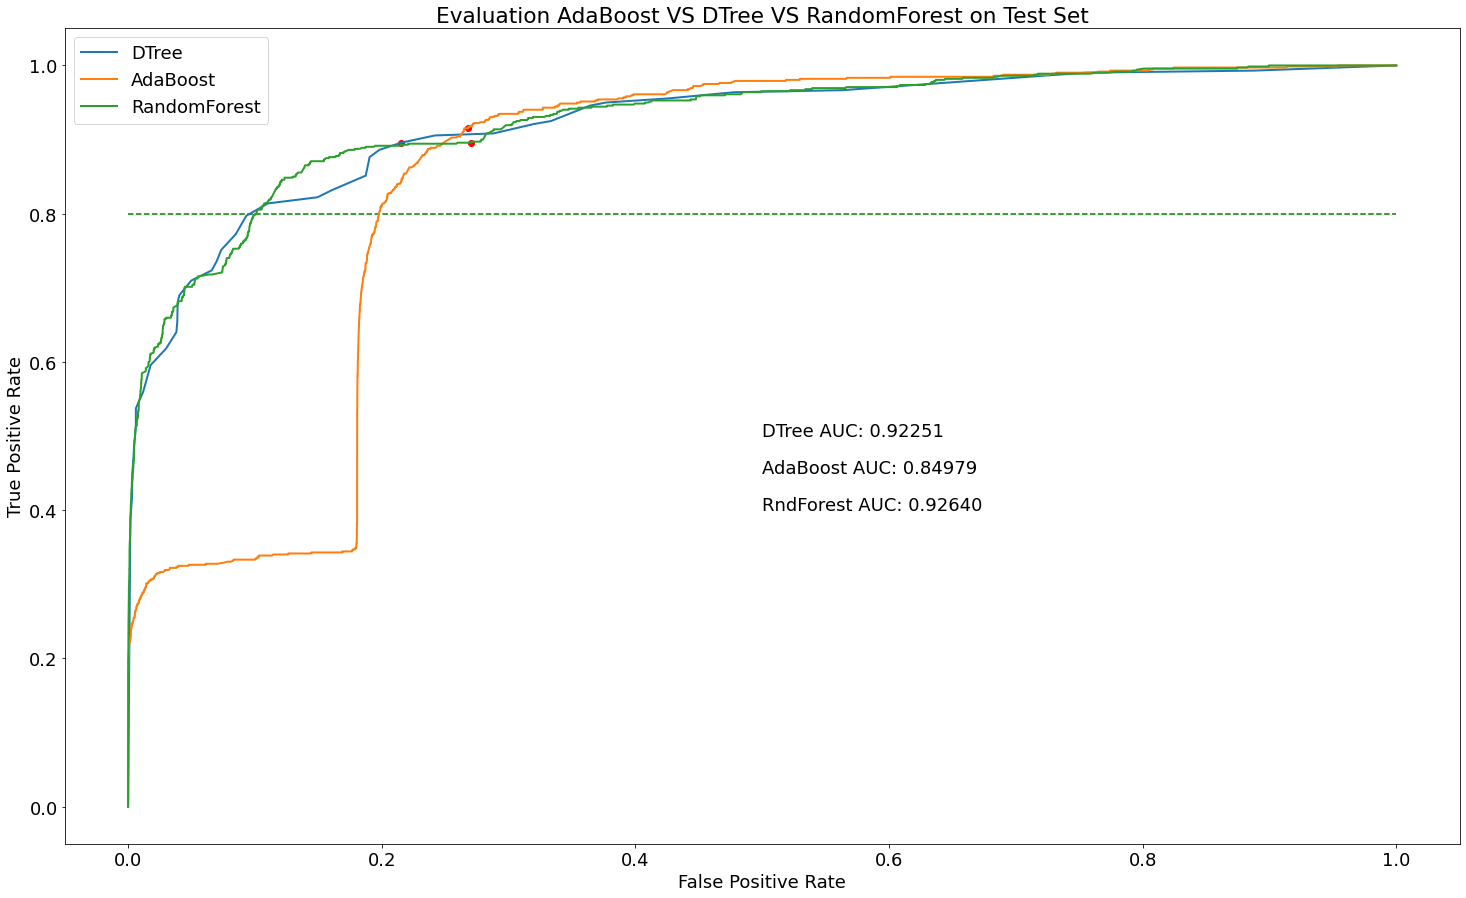

In [34]:
plt.plot(dt_fpr, dt_tpr, label="DTree", linewidth=2)
dt_mid_threshold = np.argmin(abs(dt_threshold-.50))
plt.scatter(dt_fpr[dt_mid_threshold], dt_tpr[dt_mid_threshold], color='r')
plt.text(.5, .5, "DTree AUC: {:.5f}".format(roc_auc_score(yy, all_test_data["y_dt"])))
print("[Info] DTree: Threshold: {:.2f} => TPR: {:.3f}, FPR={:.3f}".format(dt_threshold[dt_mid_threshold], dt_tpr[dt_mid_threshold], dt_fpr[dt_mid_threshold]))

plt.plot(ada_fpr, ada_tpr, label="AdaBoost", linewidth=2)
ada_mid_threshold = np.argmin(abs(ada_threshold-.50))
plt.scatter(ada_fpr[ada_mid_threshold], ada_tpr[ada_mid_threshold], color='r')
plt.text(.5, .45, "AdaBoost AUC: {:.5f}".format(roc_auc_score(yy, all_test_data["y_ada"])))
print("[Info] AdaBoost: Threshold: {:.2f} => TPR: {:.3f}, FPR={:.3f}".format(ada_threshold[ada_mid_threshold], ada_tpr[ada_mid_threshold], ada_fpr[ada_mid_threshold]))

plt.plot(rf_fpr, rf_tpr, label="RandomForest", linewidth=2)
rf_mid_threshold = np.argmin(abs(rf_threshold-.50))
plt.scatter(rf_fpr[rf_mid_threshold], rf_tpr[rf_mid_threshold], color='r')
plt.text(.5, .40, "RndForest AUC: {:.5f}".format(roc_auc_score(yy, all_test_data["y_rf"])))
print("[Info] RandomForest: Threshold: {:.2f} => TPR: {:.3f}, FPR={:.3f}".format(rf_threshold[rf_mid_threshold], rf_tpr[rf_mid_threshold], rf_fpr[rf_mid_threshold]))

plt.hlines(.80, 0, 1, color='g', linestyle='dashed')
plt.title("Evaluation AdaBoost VS DTree VS RandomForest on Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [35]:
# best model: Random forest
# assuming we aim .80 tpr
id_tpr80 = np.argmin(abs(rf_tpr-.80))
print("[Info] RandomForest: Threshold: {:.3f} => TPR: {:.3f}, FPR: {:.3f}".format(rf_threshold[id_tpr80], 
                                                                                  rf_tpr[id_tpr80], 
                                                                                  rf_fpr[id_tpr80]))

[Info] RandomForest: Threshold: 0.735 => TPR: 0.800, FPR: 0.100


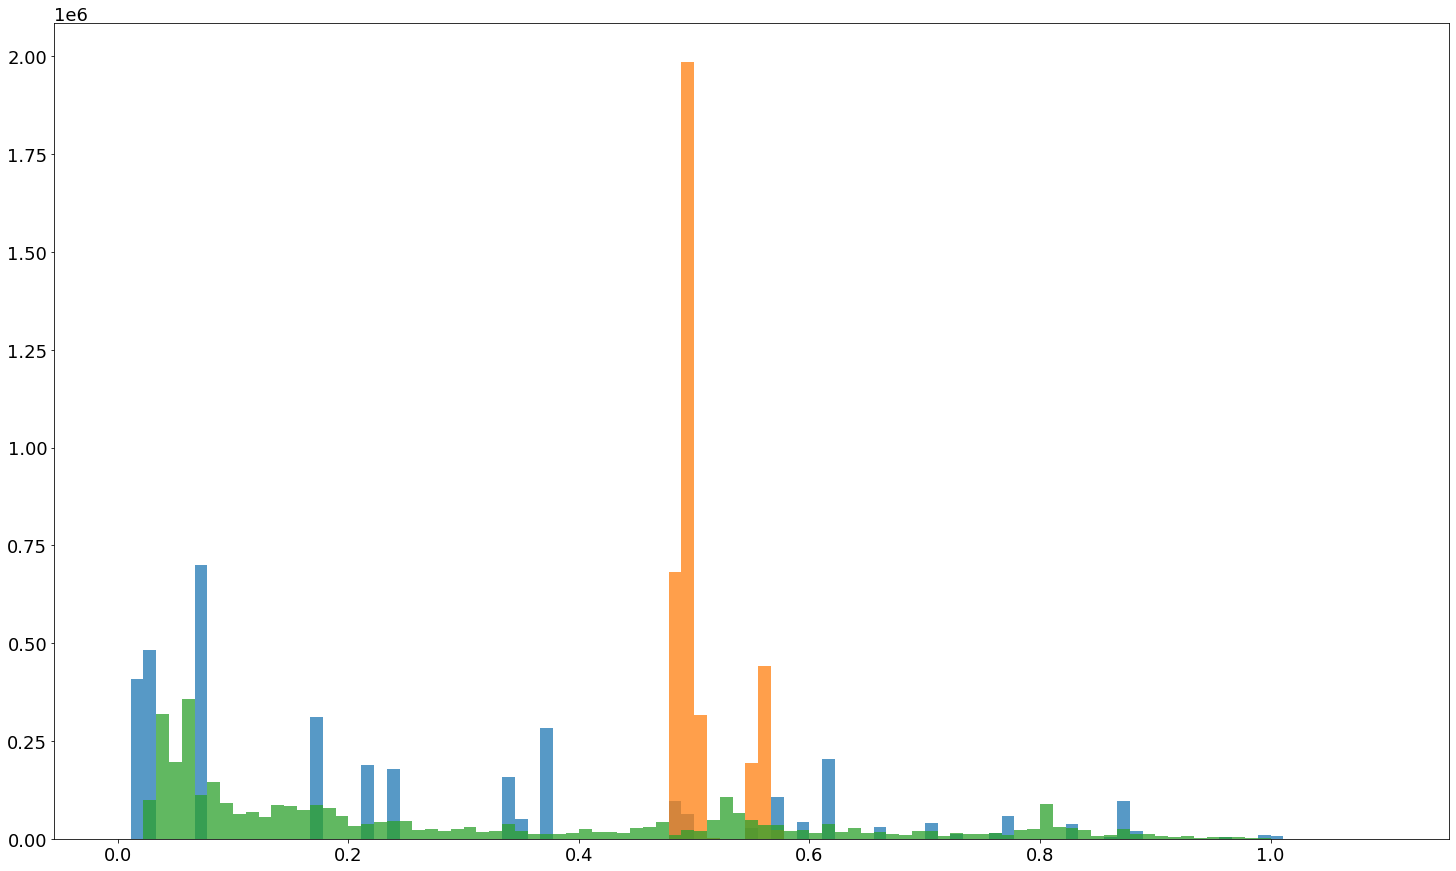

In [36]:
bins=np.linspace(0, 1.1, 100)
plt.hist(all_test_data["y_dt"], bins=bins, alpha=.75)
plt.hist(all_test_data["y_ada"], bins=bins, alpha=.75)
plt.hist(all_test_data["y_rf"], bins=bins, alpha=.75)
plt.show()

# see single ar39 subclasses

In [61]:
fprates = []
for ar39 in [-1, -2, -3, -4]:
    dt_fpr_ar39 = len(all_test_data[(all_test_data.y==ar39) & (all_test_data.y_dt>.5)]) / len(all_test_data[all_test_data.y==ar39])
    ada_fpr_ar39 = len(all_test_data[(all_test_data.y==ar39) & (all_test_data.y_ada>.5)]) / len(all_test_data[all_test_data.y==ar39])
    rf_fpr_ar39 = len(all_test_data[(all_test_data.y==ar39) & (all_test_data.y_rf>.5)]) / len(all_test_data[all_test_data.y==ar39])
    fprates.append([dt_fpr_ar39, ada_fpr_ar39, rf_fpr_ar39,])

In [62]:
fprates

[[0.1160826201883006, 0.21199728957981992, 0.16277891674117437],
 [0.1729297284824799, 0.24170142807183262, 0.21990239165678205],
 [0.20408398748229864, 0.2639845102187101, 0.27216821972412103],
 [0.2412548008139392, 0.31141722351129125, 0.34422209386856806]]

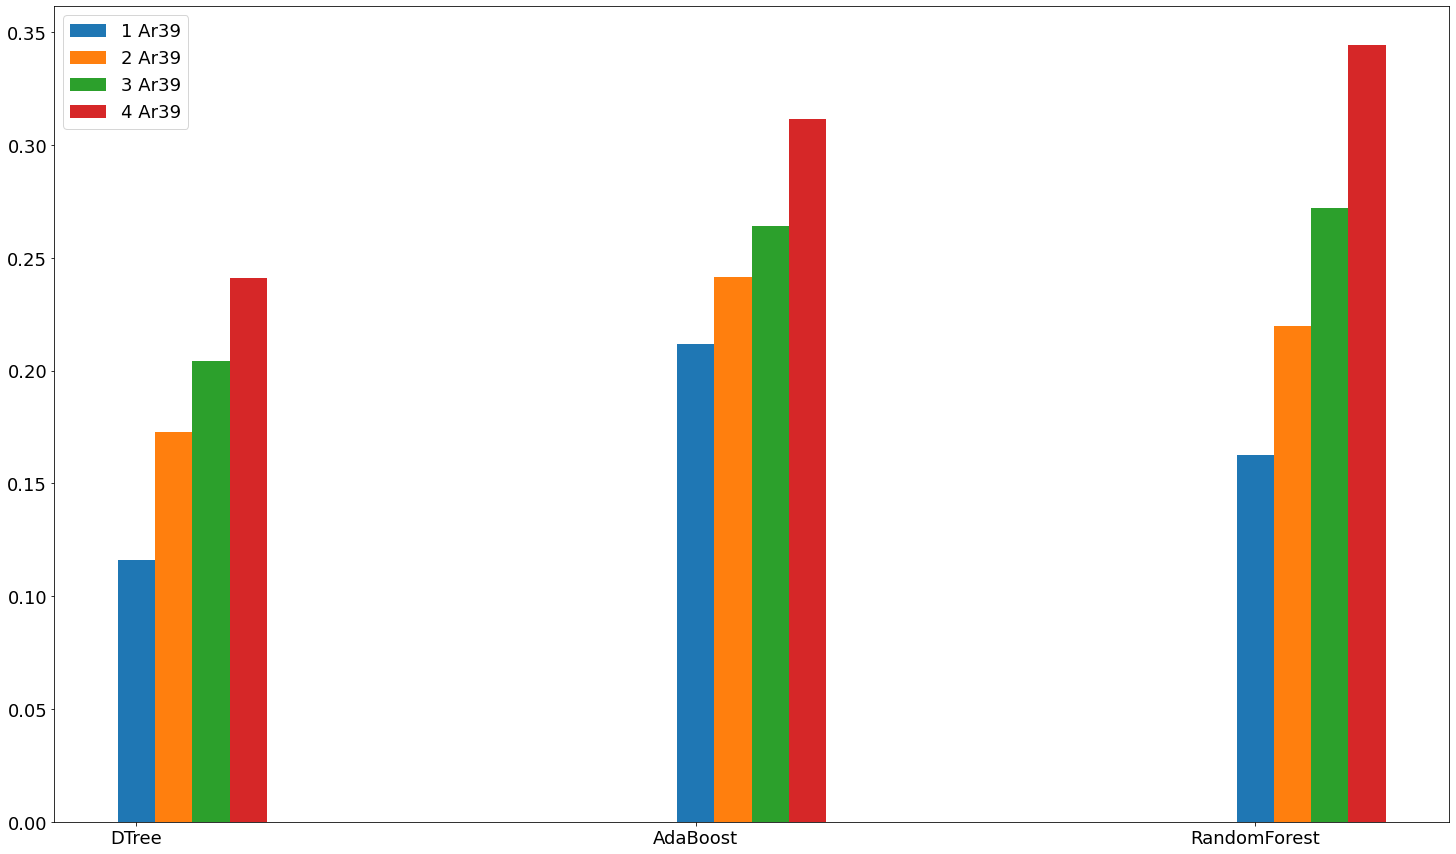

In [63]:
plt.bar(np.linspace(0, 3, 3) +.0, fprates[0], width=.1, label="1 Ar39")
plt.bar(np.linspace(0, 3, 3) +.1, fprates[1], width=.1, label="2 Ar39")
plt.bar(np.linspace(0, 3, 3) +.2, fprates[2], width=.1, label="3 Ar39")
plt.bar(np.linspace(0, 3, 3) +.3, fprates[3], width=.1, label="4 Ar39")
plt.xticks(np.linspace(0, 3, 3), ["DTree", "AdaBoost", "RandomForest"])
plt.legend()
plt.show()

# save models

In [64]:
from joblib import dump

In [77]:
dump(dt, 'models/dt_08_09_2020.joblib') 
dump(ada, 'models/ada_08_09_2020.joblib') 
dump(rf, 'models/rf_08_09_2020.joblib') 
print("[Info] Saved models.")

[Info] Saved models.


# load model dtree

In [15]:
from joblib import load

clf = load('models/dt_08_09_2020.joblib')

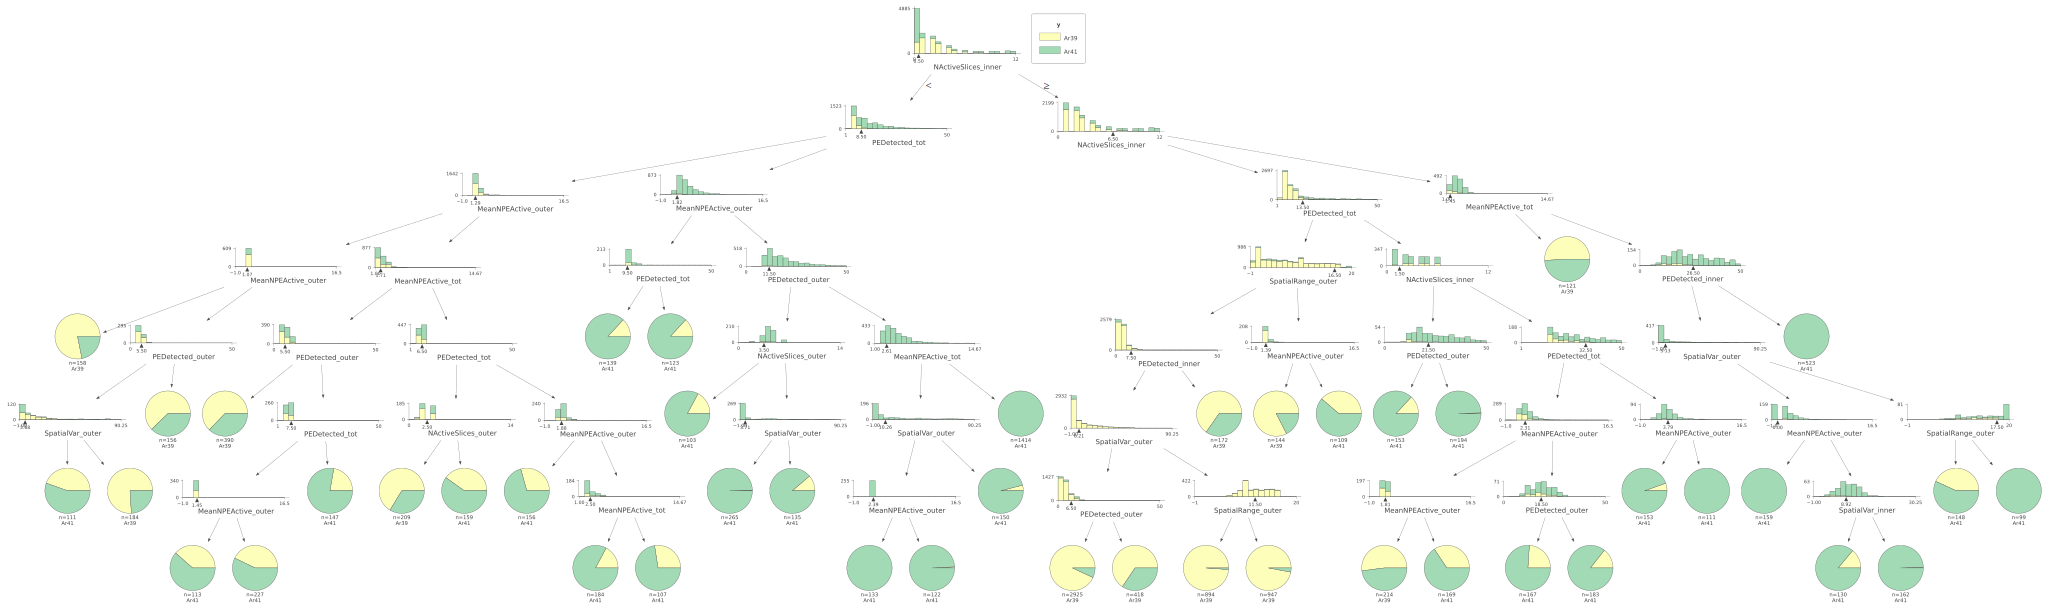

In [19]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(clf, X, y,
                target_name="y",
                feature_names=selected_features,
                class_names=["Ar39", "Ar41"])
viz

In [20]:
viz.save("prova.svg")

In [1]:
elastic_time = 0.038
dt_time = 0.266
logit_time = 0.117
rf_time = 7.712
ada_time = 108.505
svm_time = 528.646

In [2]:
import matplotlib.pyplot as plt

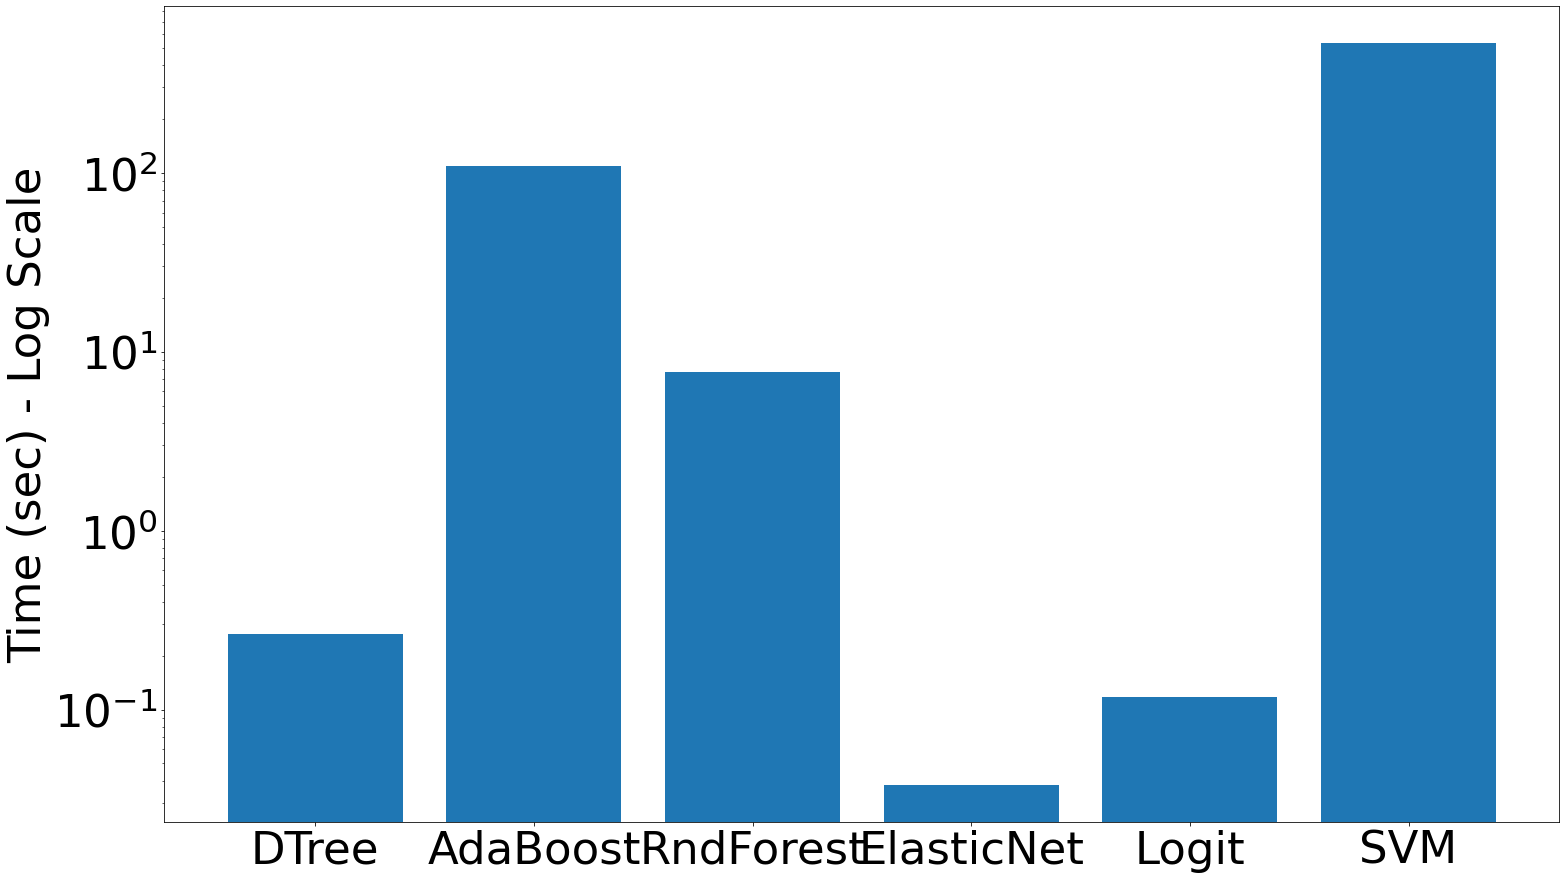

In [13]:
plt.bar(range(6), [dt_time, ada_time, rf_time, elastic_time, logit_time, svm_time])
plt.xticks(range(6), ["DTree", "AdaBoost", "RndForest", "ElasticNet", "Logit", "SVM"])
plt.yscale("log")
plt.ylabel("Time (sec) - Log Scale")
plt.show()